In [18]:
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt 
from matplotlib import style
import os
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import pickle
import requests

style.use('ggplot')
api_key=open('datasets/key.txt','r').read()

In [ ]:
def save_sp500_tickers():
	resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
	soup = bs.BeautifulSoup(resp.text, 'lxml')
	table = soup.find('table',{'class':'wikitable sortable'})
	tickers = []
	for row in table.findAll('tr')[1:]:
		ticker = row.findAll('td')[1].text
		mapping = str.maketrans(".","-") 
#Wikipedia uses "." instead of "-" in their list. 
#Had to translate "." to "-" so it would get past Berkshire Hathaway.
#Just for anyone running into this.﻿
		ticker = ticker.translate(mapping)
		tickers.append(ticker)

	with open('datasets/sp500tickers.pickle','wb') as f:
		pickle.dump(tickers, f)
	# print(tickers)
	return tickers

# save_sp500_tickers()

In [ ]:
def get_data_from_api(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('datasets/sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)

    if not os.path.exists('datasets/stock_dfs'):
        os.makedirs('datasets/stock_dfs')

    start = dt.datetime(2000,1,1)
    end = dt.datetime.now()
    for ticker in tickers:
        if not os.path.exists('datasets/stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker,'quandl',start, end, access_key=api_key)
            df.to_csv('datasets/stock_dfs/{}.csv'.format(ticker))
            print("data saved for " + ticker)
        else:
            print(f'already have {ticker}')

# get_data_from_api()


In [ ]:
def compile_data():
	with open('datasets/sp500tickers.pickle','rb') as f:
		tickers = pickle.load(f)

	main_df = pd.DataFrame() #empty dataframe

	for count,ticker in enumerate(tickers):
		#mapping = str.maketrans(".","-")
		#ticker = ticker.translate(mapping)
		df = pd.read_csv('datasets/stock_dfs/{}.csv'.format(ticker))
		df.rename(columns = {'begins_at':'Date'}, inplace =True)
		df.set_index('Date',inplace=True)
		df.rename(columns = {'close_price':ticker}, inplace =True)
		df.drop(['symbol','high_price','interpolated','low_price','open_price','session','volume'], 1, inplace=True)
		if main_df.empty:
			main_df=df
		else:
			main_df = main_df.join(df,how='outer') #think if it as a sql join lose data ff no data availale


		if count%10==0:
			print(count)

	print(main_df.head())
	main_df.to_csv('datasets/sp500_joined_closes.csv')

compile_data()

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000 -0.266361  0.409801 -0.619630 -0.048954 -0.323765 -0.496590   
ABT  -0.266361  1.000000  0.433986  0.860786  0.895935  0.808672  0.920485   
ABBV  0.409801  0.433986  1.000000  0.207204  0.556960  0.426278  0.271545   
ABMD -0.619630  0.860786  0.207204  1.000000  0.764897  0.845967  0.965812   
ACN  -0.048954  0.895935  0.556960  0.764897  1.000000  0.831054  0.824954   

           AMD       AAP       AES  ...      WYNN       XEL       XRX  \
MMM  -0.405837 -0.434822 -0.694409  ... -0.040240  0.037052  0.495779   
ABT   0.660229  0.899807  0.778941  ...  0.305790 -0.347901 -0.626700   
ABBV -0.053850  0.222548 -0.073108  ...  0.446523 -0.609825  0.060928   
ABMD  0.574272  0.849082  0.859208  ...  0.375640 -0.373019 -0.779549   
ACN   0.518420  0.822667  0.607422  ...  0.328597 -0.363603 -0.610220   

          XLNX        XL       XYL       YUM       ZBH      ZION       ZTS  
MMM   0.297755 

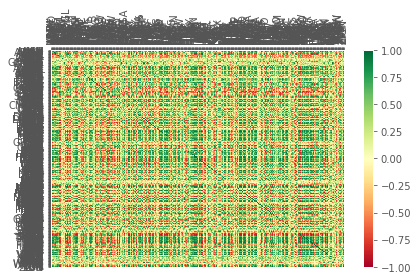

In [48]:
def visualize_data():
	df = pd.read_csv('datasets/sp500_joined_closes.csv')
	# df['AAPL'].plot()
	# plt.show()
	df_corr=df.corr()

	print(df_corr.head())

	data=df_corr.values
	fig=plt.figure()
	ax=fig.add_subplot(1,1,1)

	heatmap=ax.pcolor(data, cmap=plt.cm.RdYlGn)
	fig.colorbar(heatmap)
	ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
	ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)
	ax.invert_yaxis()
	ax.xaxis.tick_top()

	column_labels=df_corr.columns
	row_labels=df_corr.index

	ax.set_xticklabels(column_labels)
	ax.set_yticklabels(row_labels)
	plt.xticks(rotation=90)
	heatmap.set_clim(-1,1)
	plt.tight_layout()
	plt.show()

visualize_data()